In [1]:
from google.colab import drive
import os
import sys
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
cls_filepath ="drive/MyDrive/NLU Coursework/" #Path to the directory containing the classes folder

model_weight_filepath = "drive/MyDrive/NLU Coursework/solution_B/models_B/solution_B.hdf5" #Path to the model weights to be demoed
model_arch_filepath = "drive/MyDrive/NLU Coursework/solution_B/models_B/solution_B.json" #Path to the model architecture to be demoed

dataset_path = "drive/MyDrive/NLU Coursework/data/training_data/training_data/NLI/dev.csv" #Path to the dataset used for evaluation
labels_path = "drive/MyDrive/NLU Coursework/submissions/Group_17_B.csv" #Path to output the predicted labels

# Evaluation Setup

In [13]:
sys.path.append(cls_filepath) #Path to import the helper methods & classes from. Classes directory must be within this folder
from classes.evaluation import evaluate, draw_confusion_matrix, most_confused_samples
from classes.preprocessing import load_data_csv

In [26]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
import keras
from transformers import XLNetTokenizer, XLNetModel

In [28]:
import json
from random import randint
import os
import random
from nltk.corpus import wordnet, stopwords
from itertools import chain
import nltk
import typing
import numpy as np
import pandas as pd

In [10]:
PADDING: str = "post"
def tokenize_data(tokenizer: XLNetTokenizer, premises: typing.List[str], hypotheses: typing.List[str]) ->typing.Tuple[np.array, np.array]:
  """
  Uses the input tokenizer to tokenizer the premises & hypotheses. Will then pad the sequences correctly, using the maxlen passed in
  """
  premises = [tokenizer.encode(premise, add_special_tokens=True) for premise in premises]
  hypotheses = [tokenizer.encode(hypothesis, add_special_tokens=True) for hypothesis in hypotheses]

  premises = pad_sequences(premises, maxlen=MAX_PREMISE_LENGTH, padding=PADDING, value=0)
  hypotheses = pad_sequences(hypotheses, maxlen=MAX_HYPOTHESIS_LENGTH, padding=PADDING, value=0)

  return (np.array(premises), np.array(hypotheses))

# Data Preprocessing

In [15]:
premises, hypotheses, true = load_data_csv(filepath=dataset_path)
true = np.array([int(x) for x in true])

In [16]:
premises_og = premises
hypotheses_og = hypotheses

In [17]:
MAX_PREMISE_LENGTH: int = 110
MAX_HYPOTHESIS_LENGTH: int = 60

print(f"MAX_PREMISE_LENGTH: {MAX_PREMISE_LENGTH}")
print(f"MAX_HYPOTHESIS_LENGTH: {MAX_HYPOTHESIS_LENGTH}")

MAX_PREMISE_LENGTH: 110
MAX_HYPOTHESIS_LENGTH: 60


In [18]:
labels = to_categorical(true)

### Example

In [19]:
index = randint(0, len(premises))
print(f"Premise: {premises[index]}")
print(f"Hypothesis: {hypotheses[index]}")
print(f"Label: {labels[index]}")

Premise: couple of little cabinets and and uh sleeping  on either end of the the canvas when you open it up it's just all screened in so it's pretty neat uh
Hypothesis: The sleeping areas are small too.
Label: [0. 1.]


## Tokenize Data

In [20]:
BERT_ID = 'xlnet-base-cased'
tokenizer = XLNetTokenizer.from_pretrained(BERT_ID, do_lower_case=False)
bert_model = XLNetModel.from_pretrained(BERT_ID)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


spiece.model:   0%|          | 0.00/798k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.38M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/760 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/467M [00:00<?, ?B/s]

In [21]:
premises, hypotheses = tokenize_data(tokenizer=tokenizer, premises=list(premises), hypotheses=list(hypotheses))

In [22]:
VOCAB_SIZE = tokenizer.vocab_size
print(f"Vocabulary size: {VOCAB_SIZE}")

Vocabulary size: 32000


### Example

In [23]:
#Premise
print(f"Sentence: {tokenizer.convert_ids_to_tokens(premises[index])}")
print(f"Tokens: {premises[index]}")

Sentence: ['▁couple', '▁of', '▁little', '▁cabinet', 's', '▁and', '▁and', '▁', 'uh', '▁sleeping', '▁on', '▁either', '▁end', '▁of', '▁the', '▁the', '▁canvas', '▁when', '▁you', '▁open', '▁it', '▁up', '▁it', "'", 's', '▁just', '▁all', '▁screened', '▁in', '▁so', '▁it', "'", 's', '▁pretty', '▁neat', '▁', 'uh', '<sep>', '<cls>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>']
Tokens: [ 1259    20   293  4053    2

In [24]:
#Hypothesis
print(f"Sentence: {tokenizer.convert_ids_to_tokens(hypotheses[index])}")
print(f"Tokens: {hypotheses[index]}")

Sentence: ['▁The', '▁sleeping', '▁areas', '▁are', '▁small', '▁too', '.', '<sep>', '<cls>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>', '<unk>']
Tokens: [  32 6817  689   41  316  269    9    4    3    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0]


# Load Model

In [27]:
with open(model_arch_filepath, "r") as f:
    model_architecture = json.loads(f.read())

model = keras.models.model_from_json(model_architecture)
model.load_weights(model_weight_filepath)

# Make Predictions

In [29]:
predicted_logits = model.predict(x=[premises, hypotheses])
predicted_labels = np.argmax(predicted_logits, axis=1)

211/211 [==============================] - 6s 15ms/step


In [30]:
output_labels = pd.DataFrame(
    predicted_labels,
    columns=["prediction"]
)
output_labels.to_csv(labels_path, index=False)
output_labels

,prediction
0,1
1,0
2,1
3,1
4,1
...,...
6732,0
6733,0
6734,1
6735,0


# Evaluation

In [31]:
#Evaluation Metrics
test_metrics = evaluate(true_labels=true, predicted_logits=np.array(predicted_logits))
test_metrics.to_csv("solution_B_metrics.csv", index=False)
test_metrics

,Accuracy,Precision,Macro Precision,Weighted Macro Precision,Recall,Macro Recall,Weighted Macro Recall,F1-Score,Macro F1-Score,Weighted Macro F1-Score,MCC,Loss
0,0.727772,0.728207,0.72774,0.727755,0.754169,0.726885,0.727772,0.74096,0.727065,0.727516,0.454624,0.535476


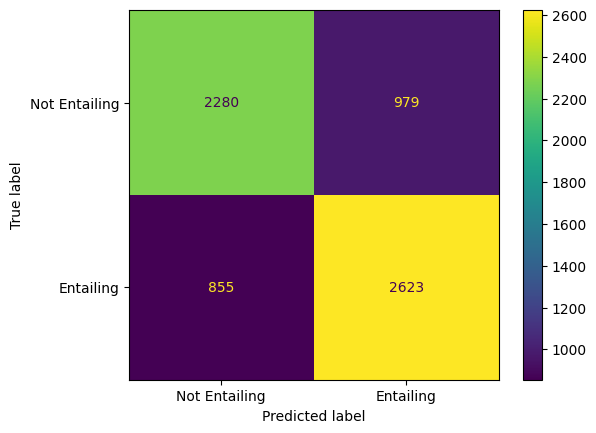

In [32]:
#Confusion matrix
conf_mat = draw_confusion_matrix(true_labels=true, predicted_logits=np.array(predicted_logits))

In [33]:
#Show the most confused samples
df = most_confused_samples(true_logits=to_categorical(true), predicted_logits=np.array(predicted_logits), premises=premises_og, hypotheses=hypotheses_og, num=10)
df

,Premise,Hypothesis,Loss,Predicted Label,True Label
0,He was the first scholar to describe in detail.,He was the first scholar to describe in detail...,11.881137,1,0
1,"La Barredora (""The Sweeper Truck"") is a crimin...","La Barredora (""The Sweeper Truck"") is a crimin...",6.591391,1,0
2,"Today, Italy; tomorrow, who knows?",The trip to Italy will deplete my bank account...,5.636950,1,0
3,Traditional examples of background music inclu...,Traditional examples of background music inclu...,5.580024,1,0
4,Association for Federal Information Resources ...,The Government Executive magazine provides add...,5.529576,0,1
5,"Bryant for introducing the bill, Payne said.","Since the bill had already been introduced, Pa...",5.411198,1,0
6,no i'm sure you know that's one thing you don'...,I don't know whether you know if you should do...,5.375714,1,0
7,It's that interaction with fiscal policy that ...,It's that interaction with the criminal law is...,5.345931,1,0
8,"However, we are so sophisticated psychometrica...",No research can be dissected by methodology al...,5.317111,0,1
9,you want to have that coverage so anyway uh bu...,No press is bad press,5.285258,0,1
